In [1]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/" #URL für Repo
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz" #URL für Daten

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)   #http-GET
    housing_tgz = tarfile.open(tgz_path)                #file wird geöffnet
    housing_tgz.extractall(path=housing_path)           #tar wird extrahiert
    housing_tgz.close()
    
import pandas as pd

# Import der Daten in Python
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv") 
    return pd.read_csv(csv_path)

import numpy as np

def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices  = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]
    
from sklearn.model_selection import StratifiedShuffleSplit

def strat_split_data(housing):
    housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3., 4.5, 6., np.inf], labels=[1,2,3,4,5])
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(housing,housing["income_cat"]):
        strat_train_set = housing.loc[train_index]
        strat_test_set = housing.loc[test_index]
    for set_ in (strat_train_set, strat_test_set):
        set_.drop("income_cat", axis=1, inplace=True)
    return strat_train_set, strat_test_set

def create_attribute_combinations(data):
    data["rooms_per_household"] = data["total_rooms"]/data["households"]
    data["bedrooms_per_room"] = data["total_bedrooms"]/data["total_rooms"]
    data["population_per_household"] = data["population"]/data["households"]
    
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:,households_ix]
        population_per_household = X[:,population_ix] / X[:,households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix] / X[:,rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
    
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standart deviation:", scores.std())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


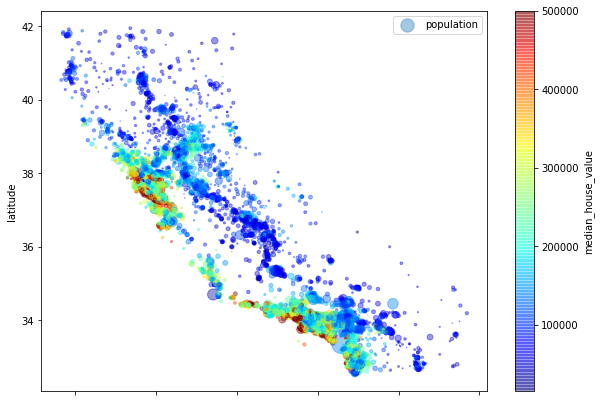

In [2]:
housing = load_housing_data()
strat_train_set, strat_test_set = strat_split_data(housing)
housing = strat_train_set.copy()
housing.info()
housing.head(10)

%matplotlib inline
import matplotlib.pyplot as plt
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population",
             figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
housing = strat_train_set.drop("median_house_value", axis=1)
housing_lables = strat_train_set["median_house_value"].copy()
housing.dropna(subset=["total_bedrooms"]) #Get rid of the corresponding districts with no total_bedr
housing_num = housing.drop("ocean_proximity", axis=1) #drop non numerical values

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_lables)
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_lables, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)
scores = cross_val_score(lin_reg, housing_prepared, housing_lables, 
                         scoring="neg_mean_squared_error", cv = 10)
lin_rsme_scores = np.sqrt(-scores)
print("LinearRegression")

display_scores(lin_rsme_scores)

68628.19819848922
LinearRegression
Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standart deviation: 2731.674001798348


In [4]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_lables)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_lables, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
scores = cross_val_score(tree_reg, housing_prepared, housing_lables, 
                         scoring="neg_mean_squared_error", cv = 10)
tree_rsme_scores = np.sqrt(-scores)
print("Tree")
display_scores(tree_rsme_scores)


Tree
Scores: [68156.99070527 66174.19541107 71836.32852601 67526.94097018
 71736.74354276 74492.30515861 70036.83974813 71706.19107808
 78235.11143172 70741.04892718]
Mean: 71064.26954990107
Standart deviation: 3326.719606816334


In [5]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_lables)
forest_predictions= forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_lables, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse
scores = cross_val_score(forest_reg, housing_prepared, housing_lables, 
                         scoring="neg_mean_squared_error", cv = 10)
forest_rsme_scores = np.sqrt(-scores)
print("Forest")
display_scores(forest_rsme_scores)

Forest
Scores: [49633.41381882 47792.95243822 49842.67062582 52267.55844089
 49610.50316985 53570.39764233 48805.24099844 47536.64697601
 52632.68144613 49985.04728386]
Mean: 50167.7112840381
Standart deviation: 1929.1704671514738


In [6]:
#EVALUATION

final_model = forest_reg
X_test = strat_test_set.drop("median_house_value", axis=1)
Y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
print(final_predictions)
final_mse = mean_squared_error(Y_test, final_predictions)
final_rsme = np.sqrt(final_mse)
print(final_rsme)

[487320.71 279609.   229513.   ... 335573.01 153120.   127353.  ]
48182.27859623485


In [7]:
#CLASSIFICATION
housing_labels_classes = housing_lables.copy()
#Housing_lables is panda series

for x in housing_labels_classes:
    if x > 10:
        if x < 100000.:
            housing_labels_classes[housing_labels_classes==x]=1
        elif x < 150000.:
            housing_labels_classes[housing_labels_classes==x]=2
        elif x < 200000.:
            housing_labels_classes[housing_labels_classes==x]=3
        elif x < 250000.:
            housing_labels_classes[housing_labels_classes==x]=4
        elif x < 300000.:
            housing_labels_classes[housing_labels_classes==x]=5
        elif x < 350000.:
            housing_labels_classes[housing_labels_classes==x]=6
        elif x < 400000.:
            housing_labels_classes[housing_labels_classes==x]=7
        elif x < 450000.:
            housing_labels_classes[housing_labels_classes==x]=8
        elif x < 500000.:
            housing_labels_classes[housing_labels_classes==x]=9
        else:
            housing_labels_classes[housing_labels_classes==x]=10

housing_labels_classes = housing_labels_classes.astype(int)        

In [8]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(housing_prepared, housing_labels_classes)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [9]:
to_test = 6
some_scores = svm_clf.decision_function([housing_prepared[to_test]])
print(some_scores)
print(svm_clf.classes_[np.argmax(some_scores)])
print("Should be " + str(housing_labels_classes[to_test]))

[[-0.32020187  0.68517302  1.68863487  2.73541594  3.85529689  5.27566208
   8.31246632  6.30325389  7.30369092  9.31753875]]
10
Should be 5


In [10]:
print("Support Vecot Machine mit 50er Klassen")
print(cross_val_score(svm_clf,housing_prepared, housing_labels_classes, cv=3, scoring="accuracy"))

Support Vecot Machine mit 50er Klassen
[0.47329215 0.47020349 0.47202035]


In [11]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()
print("Random Forest Klassifier mit 50er Klassen")
print(cross_val_score(sgd_clf, housing_prepared, housing_labels_classes, cv=3, scoring="accuracy"))

Random Forest Klassifier mit 50er Klassen
[0.36028343 0.32067587 0.36827762]


In [12]:
housing_labels_classes_bigger = housing_lables.copy()
#Housing_lables is panda series

for x in housing_labels_classes_bigger:
    if x > 6:
        if x < 100000:
            housing_labels_classes_bigger[housing_labels_classes_bigger==x]=1
        elif x < 200000: 
            housing_labels_classes_bigger[housing_labels_classes_bigger==x]=2
        elif x < 300000: 
            housing_labels_classes_bigger[housing_labels_classes_bigger==x]=3
        elif x < 400000: 
            housing_labels_classes_bigger[housing_labels_classes_bigger==x]=4
        elif x < 500000: 
            housing_labels_classes_bigger[housing_labels_classes_bigger==x]=5
        else:
            housing_labels_classes_bigger[housing_labels_classes_bigger==x]=6
            
housing_labels_classes_bigger = housing_labels_classes_bigger.astype(int)        

In [13]:
print("Support Vector Machine mit 100er Klasses")
print(cross_val_score(svm_clf,housing_prepared, housing_labels_classes_bigger, cv=3, scoring="accuracy"))

Support Vector Machine mit 100er Klasses
[0.64135174 0.63571948 0.64335029]


In [14]:
print("Random Forest Classifier mit 100er Klassed")
print(cross_val_score(sgd_clf, housing_prepared, housing_labels_classes_bigger, cv=3, scoring="accuracy"))

Random Forest Classifier mit 100er Klassed
[0.51998547 0.52307413 0.50563227]
